# Modeling

---

## Imports

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt

# core
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, \
                            GradientBoostingClassifier, StackingClassifier, VotingClassifier

## Model Preparation

Our last major goal is to create a model predicts whether a post belongs r/Seattle or r/SeattleWA. Let us read in the data once more and train-test-split.

In [2]:
# read in r/Seattle and r/SeattleWA data
sea = pd.read_csv('../datasets/Cleaned_Seattle.csv')
sea_wa = pd.read_csv('../datasets/Cleaned_SeattleWA.csv')

In [3]:
# combine r/Seattle and r/SeattleWA data into single DataFrame
all_posts = pd.concat([sea, sea_wa])

In [4]:
# convert Seattle to 0 and SeattleWA to 1 in subreddit column
all_posts['subreddit'] = all_posts['subreddit'].map({'Seattle': 0, 'SeattleWA': 1})

Our first group of models will use strictly text data to predict the subreddit.

In [5]:
# create X (text) and y (subreddit)
X = all_posts['text']
y = all_posts['subreddit']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### Baseline Score

Before we begin modeling, we should first determine establish a baseline score. Intuitively, each subreddit accounts for roughly 50% of the posts in the dataset. If we classified any predictions as the same subreddit everytime, we would epect 50% of our predictions to be correct. This is confirmed below.

In [7]:
y.value_counts(normalize = True)

0    0.503437
1    0.496563
Name: subreddit, dtype: float64

Since the two subreddits are very similar and many people likely post on either subreddit without much thought, there is a level of randomness that we simply will not be able to predict. I would be very pleasantly surprised if our model achieves greater than 60% accuracy.

There are numerous metrics besides accuracy that one can use to assess a classification model. Since our classes are balanced and optimizing false positives seems equivalently valuable to optimizing false negatives, optimizing accuracy seems sufficient.

## Modeling with CountVectorizer

Two straightforward ways to vectorize string data is with `CountVectorizer` and `TfidfVectorizer`. We will first fit a batch of classification models with `CountVectorizer` using Pipelines and GridSearchCV. The hyperparameters chosen below are all after several iterations of hyperparameter tuning.

The classification models we will try first are:
- logistic regression
- bagging
- random forest
- AdaBoost
- gradient boosting
- multinomial naive Bayes

#### Logistic Regression

In [8]:
log_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(random_state = 42))
])

log_cvec_params = {
    'cvec__max_features': [7000, 7500],
    'cvec__max_df': [0.8, 0.825],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2), (1,3)],
    'lr__max_iter': [200]
}

log_cvec_gs = GridSearchCV(log_cvec_pipe,
                     param_grid = log_cvec_params)

log_cvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             param_grid={'cvec__max_df': [0.8, 0.825],
                         'cvec__max_features': [7000, 7500],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english'],
                         'lr__max_iter': [200]})

In [9]:
print(log_cvec_gs.best_params_)
print('Train:', log_cvec_gs.score(X_train, y_train))
print('Test:', log_cvec_gs.score(X_test, y_test))

{'cvec__max_df': 0.8, 'cvec__max_features': 7000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'lr__max_iter': 200}
Train: 0.982205446211917
Test: 0.5545675020210186


Our model is massively overfit. I am quite surprised to see this much overfitting with logistic regression but we are using 7,500 features. I am however very happy to see an accuracy score of 55.4%.

*Initially I tried using max features hyperparameter values near 2,000 since I saw the most value in looking at the top 2,000 words during my analysis. GridSearchCV reminded me that there were more than 10,000 words and that I could try to incorporate more words into the model than the analysis.*

#### Bagging

In [10]:
bag_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(random_state = 42))
])

bag_cvec_params = {
    'cvec__max_features': [7000, 7500],
    'cvec__max_df': [0.8, 0.825],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2), (1,3)],
    'bag__n_estimators': [7, 10, 15],
    'bag__max_features': [0.6, 0.8, 1],
    

}

bag_cvec_gs = GridSearchCV(bag_cvec_pipe,
                     param_grid = bag_cvec_params)

bag_cvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bag',
                                        BaggingClassifier(random_state=42))]),
             param_grid={'bag__max_features': [0.6, 0.8, 1],
                         'bag__n_estimators': [7, 10, 15],
                         'cvec__max_df': [0.8, 0.825],
                         'cvec__max_features': [7000, 7500],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english']})

In [11]:
print(bag_cvec_gs.best_params_)
print('Train:', bag_cvec_gs.score(X_train, y_train))
print('Test:', bag_cvec_gs.score(X_test, y_test))

{'bag__max_features': 0.8, 'bag__n_estimators': 15, 'cvec__max_df': 0.8, 'cvec__max_features': 7000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}
Train: 0.9919115664599623
Test: 0.5165723524656427


It is not nearly as surprising that bagging produced a very overfit model compared to logistic regression since bagging averages the results of many decision trees. I was hopeful that using smaller choices of `max_features` would combat the overfitting, but even after GridSearchCV chose a value of 0.6, the model is still very overfit. This is hardly any better than the baseline accuracy.

#### Random Forest

In [12]:
rf_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

rf_cvec_params = {
    'cvec__max_features': [7000, 7500],
    'cvec__max_df': [0.8, 0.85],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2), (1,3)],
    'rf__n_estimators': [150, 200],
    'rf__max_samples': [0.4, 0.6, 1],

}

rf_cvec_gs = GridSearchCV(rf_cvec_pipe,
                     param_grid = rf_cvec_params)

rf_cvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [7000, 7500],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english'],
                         'rf__max_samples': [0.4, 0.6, 1],
                         'rf__n_estimators': [150, 200]})

In [13]:
print(rf_cvec_gs.best_params_)
print('Train:', rf_cvec_gs.score(X_train, y_train))
print('Test:', rf_cvec_gs.score(X_test, y_test))

{'cvec__max_df': 0.8, 'cvec__max_features': 7500, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'rf__max_samples': 0.6, 'rf__n_estimators': 150}
Train: 0.9948773254246428
Test: 0.5578011317704122


Another strong test score. Again, it is very overfit, but it is worth considering for our final production model. Another plus is that logistic regression has interpretability of coefficients and random forest has feature importance. Both are slight positives for these models over others.

#### AdaBoost

In [14]:
ada_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(random_state = 42))
])

ada_cvec_params = {
    'cvec__max_features': [6500, 7000],
    'cvec__max_df': [0.8, 0.85],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2), (1,3)],
    'ada__n_estimators': [50, 75, 100],

}

ada_cvec_gs = GridSearchCV(ada_cvec_pipe,
                     param_grid = ada_cvec_params)

ada_cvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'ada__n_estimators': [50, 75, 100],
                         'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [6500, 7000],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english']})

In [15]:
print(ada_cvec_gs.best_params_)
print('Train:', ada_cvec_gs.score(X_train, y_train))
print('Test:', ada_cvec_gs.score(X_test, y_test))

{'ada__n_estimators': 100, 'cvec__max_df': 0.8, 'cvec__max_features': 6500, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
Train: 0.6654084658937719
Test: 0.549717057396928


This is our first model that shows significantly less signs of overfitting. The test score is very respectable and hardly falls behind the scores attained with logistic regression and random forest. The fact that there is a lot less overfitting makes this model's results seem a bit more trustworth.

#### Gradient Boosting

In [16]:
gb_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('gb', GradientBoostingClassifier(random_state = 42))
])

gb_cvec_params = {
    'cvec__max_features': [7000, 7500],
    'cvec__max_df': [0.8, 0.85],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2), (1,3)],
    'gb__n_estimators': [100, 150],
    'gb__subsample': [0.5, 0.6, 0.7],
    'gb__max_depth': [4, 5]

}

gb_cvec_gs = GridSearchCV(gb_cvec_pipe,
                     param_grid = gb_cvec_params)

gb_cvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [7000, 7500],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english'],
                         'gb__max_depth': [4, 5],
                         'gb__n_estimators': [100, 150],
                         'gb__subsample': [0.5, 0.6, 0.7]})

In [17]:
print(gb_cvec_gs.best_params_)
print('Train:', gb_cvec_gs.score(X_train, y_train))
print('Test:', gb_cvec_gs.score(X_test, y_test))

{'cvec__max_df': 0.8, 'cvec__max_features': 7000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'gb__max_depth': 4, 'gb__n_estimators': 150, 'gb__subsample': 0.7}
Train: 0.8260986788891884
Test: 0.5731608730800324


This is our best score yet and it is much less overfit than some of our other models besides AdaBoost.

#### Multinomial Naive Bayes

In [18]:
nb_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

nb_cvec_params = {
    'cvec__max_features': [7000, 7500],
    'cvec__max_df': [0.825, 0.85],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2), (1,3)],
}

nb_cvec_gs = GridSearchCV(nb_cvec_pipe,
                     param_grid = nb_cvec_params)

nb_cvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.825, 0.85],
                         'cvec__max_features': [7000, 7500],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english']})

In [19]:
print(nb_cvec_gs.best_params_)
print('Train:', nb_cvec_gs.score(X_train, y_train))
print('Test:', nb_cvec_gs.score(X_test, y_test))

{'cvec__max_df': 0.825, 'cvec__max_features': 7000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
Train: 0.8309517390132111
Test: 0.5691188358932903


We see very comparable scores between Multinomial Bayes and Gradient Boosting without having to do any hyperparameter tuning required for the ensemble models.

## Tfidf Vectorizer

So far some accuracy scores above 55% from Logistic Regression, Random Forest, Gradient Boosting, and Multinomial Naive Bayes when we use CountVectorizer as a text transformer. Let us see if we get any increased performance by using TfidfVectorizer.

#### Logistic Regression

In [20]:
log_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 42))
])

log_tvec_params = {
    'tvec__max_features': [7000, 7500],
    'tvec__max_df': [0.8, 0.85],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2), (1,3)],
    'lr__max_iter': [100, 200]
}

log_tvec_gs = GridSearchCV(log_tvec_pipe,
                     param_grid = log_tvec_params)

log_tvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             param_grid={'lr__max_iter': [100, 200],
                         'tvec__max_df': [0.8, 0.85],
                         'tvec__max_features': [7000, 7500],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [21]:
print(log_tvec_gs.best_params_)
print('Train:', log_tvec_gs.score(X_train, y_train))
print('Test:', log_tvec_gs.score(X_test, y_test))

{'lr__max_iter': 100, 'tvec__max_df': 0.8, 'tvec__max_features': 7500, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Train: 0.863305473173362
Test: 0.5731608730800324


This model looks much better than the previous logistic regression model. It was quite a bit less overfit and boasts one of our highest test scores so far, alongside Gradient Boosting. This is a wonderful candidate for a production model. Moreover, there is the added benefit of interpretability.

#### Bagging

In [22]:
bag_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(random_state = 42))
])

bag_tvec_params = {
    'tvec__max_features': [7000, 7500],
    'tvec__max_df': [0.8, 0.85],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2), (1,3)],
    'bag__n_estimators': [7, 10, 15],
    'bag__max_features': [0.7, 0.8],
}

bag_tvec_gs = GridSearchCV(bag_tvec_pipe,
                     param_grid = bag_tvec_params)

bag_tvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bag',
                                        BaggingClassifier(random_state=42))]),
             param_grid={'bag__max_features': [0.7, 0.8],
                         'bag__n_estimators': [7, 10, 15],
                         'tvec__max_df': [0.8, 0.85],
                         'tvec__max_features': [7000, 7500],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [23]:
print(bag_tvec_gs.best_params_)
print('Train:', bag_tvec_gs.score(X_train, y_train))
print('Test:', bag_tvec_gs.score(X_test, y_test))

{'bag__max_features': 0.8, 'bag__n_estimators': 15, 'tvec__max_df': 0.8, 'tvec__max_features': 7000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}
Train: 0.9908331086546239
Test: 0.5319320937752627


Yet again, bagging performs poorly. It is still very overfit and, with the previous bagging score, secures bagging as the worst performer of our group of models.

#### Random Forest

In [24]:
rf_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

rf_tvec_params = {
    'tvec__max_features': [7000, 7500],
    'tvec__max_df': [0.825, 0.85],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2), (1,3)],
    'rf__n_estimators': [150, 200],
    'rf__max_samples': [0.4, 0.5],
}

rf_tvec_gs = GridSearchCV(rf_tvec_pipe,
                     param_grid = rf_tvec_params)

rf_tvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_samples': [0.4, 0.5],
                         'rf__n_estimators': [150, 200],
                         'tvec__max_df': [0.825, 0.85],
                         'tvec__max_features': [7000, 7500],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [25]:
print(rf_tvec_gs.best_params_)
print('Train:', rf_tvec_gs.score(X_train, y_train))
print('Test:', rf_tvec_gs.score(X_test, y_test))

{'rf__max_samples': 0.5, 'rf__n_estimators': 200, 'tvec__max_df': 0.825, 'tvec__max_features': 7000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}
Train: 0.9924507953626315
Test: 0.5375909458367018


This time Random Forest performs pretty poorly with the TfidfVectorizer.

#### AdaBoost

In [26]:
ada_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(random_state = 42))
])

ada_tvec_params = {
    'tvec__max_features': [7000, 7500],
    'tvec__max_df': [0.8, 0.825],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2), (1,3)],
    'ada__n_estimators': [100, 125]
}

ada_tvec_gs = GridSearchCV(ada_tvec_pipe,
                     param_grid = ada_tvec_params)

ada_tvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'ada__n_estimators': [100, 125],
                         'tvec__max_df': [0.8, 0.825],
                         'tvec__max_features': [7000, 7500],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [27]:
print(ada_tvec_gs.best_params_)
print('Train:', ada_tvec_gs.score(X_train, y_train))
print('Test:', ada_tvec_gs.score(X_test, y_test))

{'ada__n_estimators': 100, 'tvec__max_df': 0.8, 'tvec__max_features': 7000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}
Train: 0.695066055540577
Test: 0.5295068714632175


AdaBoost again produces one of the least overfit models. The score is definitely not great. At this point we have several models that have much stronger performances.

#### Gradient Boosting

In [28]:
gb_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier(random_state = 42))
])

gb_tvec_params = {
    'tvec__max_features': [7000, 7500],
    'tvec__max_df': [0.8, 0.85],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2), (1,3)],
    'gb__n_estimators': [100, 125],
    'gb__subsample': [0.4, 0.5],
    'gb__max_depth': [4, 5]
}

gb_tvec_gs = GridSearchCV(gb_tvec_pipe,
                     param_grid = gb_tvec_params)

gb_tvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gb__max_depth': [4, 5],
                         'gb__n_estimators': [100, 125],
                         'gb__subsample': [0.4, 0.5],
                         'tvec__max_df': [0.8, 0.85],
                         'tvec__max_features': [7000, 7500],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [29]:
print(gb_tvec_gs.best_params_)
print('Train:', gb_tvec_gs.score(X_train, y_train))
print('Test:', gb_tvec_gs.score(X_test, y_test))

{'gb__max_depth': 4, 'gb__n_estimators': 125, 'gb__subsample': 0.4, 'tvec__max_df': 0.8, 'tvec__max_features': 7500, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}
Train: 0.7988676193043948
Test: 0.5513338722716249


Gradient Boosting with the TfidfVectorizer performed worse this time, but the score is still fairly solid.

#### Multinomial Naive Bayes

In [30]:
nb_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb_tvec_params = {
    'tvec__max_features': [7250, 7500, 7750],
    'tvec__max_df': [0.8, 0.825, 0.85,],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2), (1,3)],
}

nb_tvec_gs = GridSearchCV(nb_tvec_pipe,
                     param_grid = nb_tvec_params)

nb_tvec_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.8, 0.825, 0.85],
                         'tvec__max_features': [7250, 7500, 7750],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [31]:
print(nb_tvec_gs.best_params_)
print('Train:', nb_tvec_gs.score(X_train, y_train))
print('Test:', nb_tvec_gs.score(X_test, y_test))

{'tvec__max_df': 0.8, 'tvec__max_features': 7250, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}
Train: 0.8598004853060124
Test: 0.5844785772029103


This has been our best model so far by a decent amount. It is the strongest test score and is not as egregiously overfit as some of our models.

## Voting Classifier

We have two approaches to combining the results of our strongest models into a single classification model: `VotingClassifer` and `StackingClassifier`. Below, we fit a voting classifier on our best performing models:

with `CountVectorizer`:
- logistic regression
- random forest
- gradient boosting
- multinomial naive Bayes

with `TfidfVectorizer`:
- logistic regression
- multinomial naive Bayes

There is some slight setup we must do before we can fit a voting classifier. To simplify our steps, we create several lists of pipe names, pipes, and the models we fit above.

In [58]:
# names for pipes for VotingClassifier
top_pipe_names = ['lrc', 'rfc', 'gbc', 'nbc', 'logt','nbt']

# pipes for VotingClassifier
top_pipes = [log_cvec_pipe, rf_cvec_pipe, gb_cvec_pipe, nb_cvec_pipe,
         log_tvec_pipe, nb_tvec_pipe]

# pregridsearched models with hyperparameters tuned
top_models = [log_cvec_gs, rf_cvec_gs, gb_cvec_gs, nb_cvec_gs,
                log_tvec_gs, nb_tvec_gs]

To take advantage of the thorough hyperparameter tuning we did earlier, we loop over our models insert the best parameters into the parameters dictionary for our `VotingClassifier`.

In [59]:
# aliases and pipes for voting classifers
top_pipe_tuples = list(zip(top_pipe_names, top_pipes))
voters = VotingClassifier(top_pipe_tuples)

# voting model paramters
voter_params = {}

# collect hyperparameters from gridsearch fits for voting classifier
for i, model in enumerate(top_models):
    for param_name, param_val in model.best_params_.items():
        # make sure hyperparameter names are of the form
        # (pipe name)__(transformer or estimatorname)__(parameter name)
        voter_param_name = top_pipe_names[i] + '__' + param_name
        voter_params[voter_param_name] = [param_val]

In [60]:
# fit voting classifier over best found parameters
vote_gs = GridSearchCV(voters, param_grid = voter_params)
vote_gs.fit(X_train, y_train)

GridSearchCV(estimator=VotingClassifier(estimators=[('lrc',
                                                     Pipeline(steps=[('cvec',
                                                                      CountVectorizer()),
                                                                     ('lr',
                                                                      LogisticRegression(random_state=42))])),
                                                    ('rfc',
                                                     Pipeline(steps=[('cvec',
                                                                      CountVectorizer()),
                                                                     ('rf',
                                                                      RandomForestClassifier(random_state=42))])),
                                                    ('gbc',
                                                     Pipeline(steps=[('cvec',
                                                                      CountVectorizer()),
                                                                     ('gb',
                                                                      GradientBoostingClassifier(random_state=42))])...
                         'nbc__cvec__ngram_range': [(1, 2)],
                         'nbc__cvec__stop_words': ['english'],
                         'nbt__tvec__max_df': [0.8],
                         'nbt__tvec__max_features': [7250],
                         'nbt__tvec__ngram_range': [(1, 3)],
                         'nbt__tvec__stop_words': ['english'],
                         'rfc__cvec__max_df': [0.8],
                         'rfc__cvec__max_features': [7500],
                         'rfc__cvec__ngram_range': [(1, 3)],
                         'rfc__cvec__stop_words': ['english'],
                         'rfc__rf__max_samples': [0.6], ...})

In [61]:
print('Train:', vote_gs.score(X_train, y_train))
print('Test:', vote_gs.score(X_test, y_test))

Train: 0.9212725802102992
Test: 0.5828617623282134


Our results are comparable to our best performing model multinomial naive Bayes, though VotingClassifier is a bit more overfit. So far, I would still use this voting classifier over the multinomial naive Bayes model since it seems more robust, averaging over several of our best models.

## Stacking - Our Production Model

For our final model, we use `StackingClassifiers` over the same models that we used for `VotingClassifier`. Unfortunately, it is not obvious how we can incorporate our hyperparameters into this model, or if it would even be a good idea to do so. Thus we are fitting our stacking model over the base models that performed best.

In [62]:
# pipe_tuples are already in the form for stacking
# due to setup for VotingClassifier
stack = StackingClassifier(estimators = top_pipe_tuples,
                                 final_estimator = LogisticRegression(random_state = 42))

stack.fit(X_train, y_train)

C:\Users\John\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\John\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

StackingClassifier(estimators=[('lrc',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('lr',
                                                 LogisticRegression(random_state=42))])),
                               ('rfc',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('rf',
                                                 RandomForestClassifier(random_state=42))])),
                               ('gbc',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('gb',
                                                 GradientBoostingClassifier(random_state=42))])),
                               ('nbc',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('nb', MultinomialNB())])),
                               ('logt',
                                Pipeline(steps=[('tvec', TfidfVectorizer()),
                                                ('lr',
                                                 LogisticRegression(random_state=42))])),
                               ('nbt',
                                Pipeline(steps=[('tvec', TfidfVectorizer()),
                                                ('nb', MultinomialNB())]))],
                   final_estimator=LogisticRegression(random_state=42))

In [63]:
print('Train:', stack.score(X_train, y_train))
print('Test:', stack.score(X_test, y_test))

Train: 0.9541655432731194
Test: 0.5860953920776071


Like most of the other ensemble models, this model is overfit. This will be our choice of production model as it holds the best accuracy score and, like VotingClassifier, comes from a combination of our best performing individual models.

---

## Summarizing the Results

To really compare all of the results we have collected so far, let us create a summative visual. Below we create several lists to help us create this visual.

In [64]:
# summative bar chart on model performances
# bar labels
model_names = ['Log', 'Bag', 'R Forest', 'Ada', 'Gradient', 'Mult NB', 'Vote', 'Stacking']

# pregridsearched models with hyperparameters tuned
all_models = [log_cvec_gs, bag_cvec_gs, rf_cvec_gs, ada_cvec_gs, gb_cvec_gs, nb_cvec_gs,
                log_tvec_gs, bag_tvec_gs, rf_tvec_gs, ada_tvec_gs, gb_tvec_gs, nb_tvec_gs,
                vote_gs, stack]

# accuracy scores for each classification model
all_scores = [model.score(X_test, y_test) for model in all_models]

# scores of unused models
unused_scores = [0 if i in [0,2,4,5,6,11,13] else all_scores[i] for i in range(len(all_scores))]

# scores of models used for stacking
level_1_scores = [all_scores[i] for i in [0,2,4,5,6,11]]

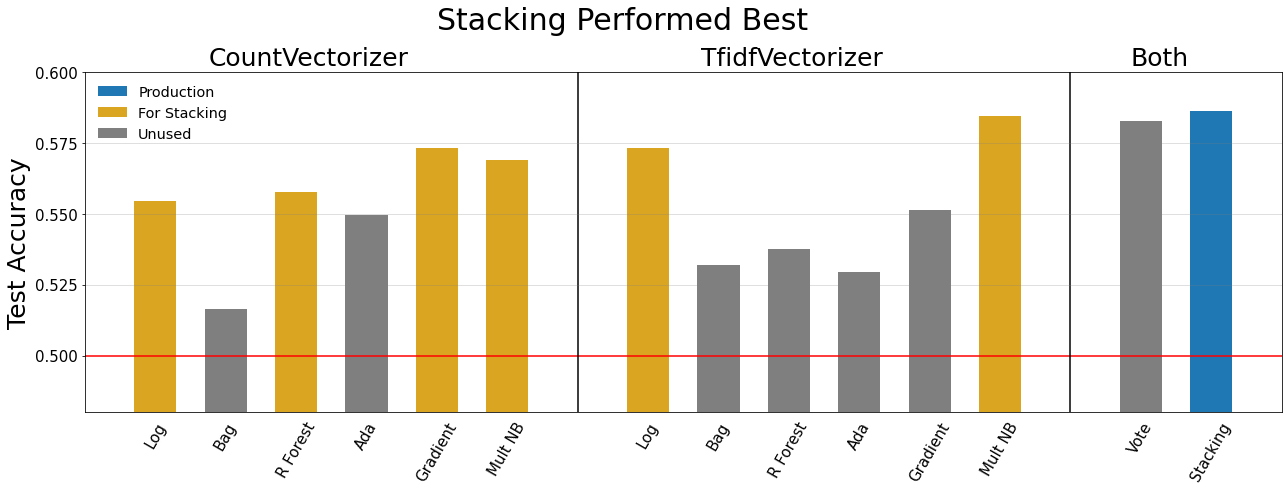

In [66]:
plt.figure(figsize = (18,7))

# plot title
plt.text(s = 'Stacking Performed Best', size = 30, x = 5, y = 0.615)

# generate x position of bars and 
# create model names as x labels for bars
x_vals = list(range(1,7)) + list(range(8,14)) + [15,16]
x_labels = 2*model_names[:6] + model_names[-2:]
plt.xticks(x_vals, labels = x_labels, rotation = 60, size = 15)
plt.yticks([0.5, 0.525, 0.55, 0.575, 0.6],size = 15)

# plot the bars
plt.bar(16, all_scores[-1], width = 0.6, color = 'tab:blue', label = 'Production')
plt.bar([1,3,5,6,8,13], level_1_scores, width = 0.6, color = 'goldenrod', label = 'For Stacking')
plt.bar(x_vals, unused_scores, width = 0.6, color = 'tab:grey', label = 'Unused')

# shape axes and create axes labels
plt.xlim([0,17])
plt.ylim([0.48,0.6])
#plt.text(s = 'Models', size = 25, x= 8, y = 0.445)
#plt.text(s = 'Test Accuracy', size = 25, rotation = 90, x = -1.05, y = 0.515)
plt.ylabel('Test Accuracy', size = 25)
plt.tick_params(axis = 'x', bottom = False)

# baseline accuracy
plt.axhline(0.5, color = 'red')

# plot subdivisions
plt.axvline(7, color = 'black')
plt.axvline(14, color = 'black')

# subdivision titles
plt.text(s = 'CountVectorizer', size = 25, x= 1.75, y = 0.6025)
plt.text(s = 'TfidfVectorizer', size = 25, x= 8.75, y = 0.6025)
plt.text(s = 'Both', size = 25, x= 14.85, y = 0.6025)

# highlight runneru-ups
#runner_ups = [model_scores[i] for i in [2,6,11,12]]
#plt.bar([3,8,13,15], runner_ups, width = 0.6, color = 'tab:blue', alpha = 0.3)


# grid
plt.axhline(0.525, color = 'gray', alpha = 0.5, linewidth = 0.5)
plt.axhline(0.55, color = 'gray', alpha = 0.5, linewidth = 0.5)
plt.axhline(0.575, color = 'gray', alpha = 0.5, linewidth = 0.5)

plt.legend(fontsize = 'x-large', frameon = False);

plt.tight_layout()
plt.savefig('../images/iteration_scores.png');

As mentioned before, our Stacking model beats our other models in terms of accuracy. The fact that it incorporates four different types of models and two different string vectorizers makes me feel a bit more confident in it than other individual models. This is our choice of production model.

## Modeling On Non Text Data

Before we conclude our project, we briefly explore using the non text data we collected to predict subreddits. Namely, we use the time of post column `created_utc`, the sentiment columns `sent_pos`, `sent_neg`, and `sent_compound`, and last the word count column `word_count`.

In [41]:
# nt for Non Text
X_nt = all_posts[['created_utc', 'sent_pos', 'sent_neg', 'sent_compound', 'word_count']]
y_nt = all_posts['subreddit']

In [42]:
X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(X_nt, y_nt, random_state = 42, stratify = y_nt)

For the sake of simplicity, let us fit a logistic regression and a random forest on our data.

In [43]:
lr = LogisticRegression()
lr.fit(X_train_nt, y_train_nt)

LogisticRegression()

In [44]:
print(lr.score(X_train_nt, y_train_nt))
print(lr.score(X_test_nt, y_test_nt))

0.5033701806416824
0.5036378334680679


Quite an unimpressive score! However, when we fit a random forest we obtain a score that massively outshines all of our previous work.

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train_nt, y_train_nt)

RandomForestClassifier()

In [46]:
print(rf.score(X_train_nt, y_train_nt))
print(rf.score(X_test_nt, y_test_nt))

0.9973038554866541
0.8342764753435732


In [47]:
pd.Series(rf.feature_importances_, index = X_nt.columns)

created_utc      0.658472
sent_pos         0.085112
sent_neg         0.060193
sent_compound    0.096375
word_count       0.099848
dtype: float64

Impressive!

Suspiciously, the model's success is coming from `created_utc`. It may be the case that when we pulled our data, we had to dig deeper into one subreddit. If this is the case, the model is simply noticing information about how the data was scraped.

Let us convert our UTC time to a datetime and reimplement the model using the time of day in which the post was created. If the model remains successful, this will be a great thing to notice. If not, it will be nice to rule it out.

In [48]:
all_posts['post_hour'] = pd.to_datetime(all_posts['created_utc'], unit = 's').apply(lambda x: x.time().hour)

In [49]:
X_nt = all_posts[['post_hour', 'sent_pos', 'sent_neg', 'sent_compound', 'word_count']]
y_nt = all_posts['subreddit']

In [50]:
X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(X_nt, y_nt, random_state = 42, stratify = y_nt)

In [51]:
lr = LogisticRegression()
lr.fit(X_train_nt, y_train_nt)

LogisticRegression()

In [52]:
print(lr.score(X_train_nt, y_train_nt))
print(lr.score(X_test_nt, y_test_nt))

0.534645456996495
0.5416329830234439


Interestingly, our logistic regression scores improve a fair bit and become somewhat comparable with some of the worse models we fit earlier.

In [53]:
rf = RandomForestClassifier()
rf.fit(X_train_nt, y_train_nt)

RandomForestClassifier()

In [54]:
print(rf.score(X_train_nt, y_train_nt))
print(rf.score(X_test_nt, y_test_nt))

0.9902938797519547
0.5036378334680679


And as expected, our random forest score takes a massive hit along with the feature importance of the time related column.

In [55]:
pd.Series(rf.feature_importances_, index = X_nt.columns)

post_hour        0.157719
sent_pos         0.207882
sent_neg         0.144532
sent_compound    0.241934
word_count       0.247933
dtype: float64

As one last example to cement our production model, we fit a KNN model on this non-text data.

In [56]:
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'knn__n_neighbors': [5,10,15]
}

knn_gs = GridSearchCV(knn_pipe, param_grid = knn_params)

knn_gs.fit(X_train_nt, y_train_nt)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 10, 15]})

In [57]:
print(knn_gs.score(X_train_nt, y_train_nt))
print(knn_gs.score(X_test_nt, y_test_nt))

0.6298193583176058
0.5092966855295069


After a few basic attempts to create models on the non text data, the scores do not seem to be any better than our lowest performing text based models.

# Conclusions

Our goals for this project were to:
- explore the text data from posts on r/Seattle and r/SeattleWA
- try to identify notable ways in how these two subreddits differ
- and build classification models to try and predict if a post is more likely to come from r/Seattle or r/SeattleWA

We were able to analyze some characteristics within the r/SeattleWA subreddit that distinguished it from r/Seattle. The main takeaway was that r/SeattleWA showed a lot of reason to believe its users are generally more Conservative than the users on r/Seattle. This can be seen by the significant difference in frequency of the following words, all of which appeared much more frequently in r/SeattleWA:
- mask, tax, drug, clean, homeless, report, crime, law, wear, gun

With r/Seattle, the most common words appear to be more general suggesting the subreddit consists of more general residents of Seattle.
- board, food, game, event, dog, line, blue

In terms of our production model, we tried numerous models and the one that performed the strongest was a StackingClassifier whose first level estimators consisted of a:
- random forest with CountVectorizer
- Gradient Boosting with CountVectorizer
- multinomial naive Bayes with CountVectorizer
- logistic regression with TfidfVectorizer
- multinomial naive Bayes with TfidfVectorizer

We stated that our original goal was an accuracy score exceeding 60%. Unfortunately, our production model slightly missed the target with an accuracy score of 58.6%. Although we were able to identify a rough distinction between the two subreddits, there are many similarities between them. It was not surprising that our models had some difficulty predicting between the two, especially with a using bag-of-words approach like CountVectorizer and TfidfVectorizer.

For future explorations, I would recommend analyzing words strictly in one subreddit and not the other. In this project, we looked at the top 2,000 words of each subredit and examined the words in common. This completely ignored any words roughly 700 words (350 from each subreddit). Most of these words would likely be uninteresting, but there may be a few illustrative gems.

Other topics we did not thoroughly examine were bi-grams and tri-grams. I looked into these very lightly, but not of the work was led to anything deep enough to include in the project. There may be some insights to draw here.

And finally, we never used comment data in our analysis. Because these subreddits share many of the same users, identical posts certainly appear on both subreddits occassionally. It could be interesting to identify examples of such posts and analyze how the comment data differ from one subreddit to the other.